# Eye for blind

Image caption generation and text to speech conversion.

In [1]:
# Install Google text to speech library
!pip install gTTS

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [50]:
#Import all the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import glob
import time
import tensorflow as tf
import keras
from collections import Counter
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from gtts import gTTS
from IPython.display import Audio 
import nltk
nltk.download('stopwords')
from PIL import Image

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import Input, layers
from nltk.translate.bleu_score import sentence_bleu

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data understanding:

Steps followed:

        1.Import the dataset and read image & captions into two seperate variables
        2.Visualise both the images & text present in the dataset
        3.Create a dataframe which summarizes the image, path & captions as a dataframe
        4.Visualise the top 30 occuring words in the captions
        5.Create a list which contains all the captions & path


In [4]:
# read image and captions
img_path = '/content/gdrive/MyDrive/Eye_for_blind/images'
text_path = '/content/gdrive/MyDrive/Eye_for_blind/captions.txt'

In [5]:
# Read all the images present in the img_path 
imgs = glob.glob(img_path + '/*.jpg',recursive=True)
print('Total images present= {}'.format(len(imgs)))

Total images present= 8091


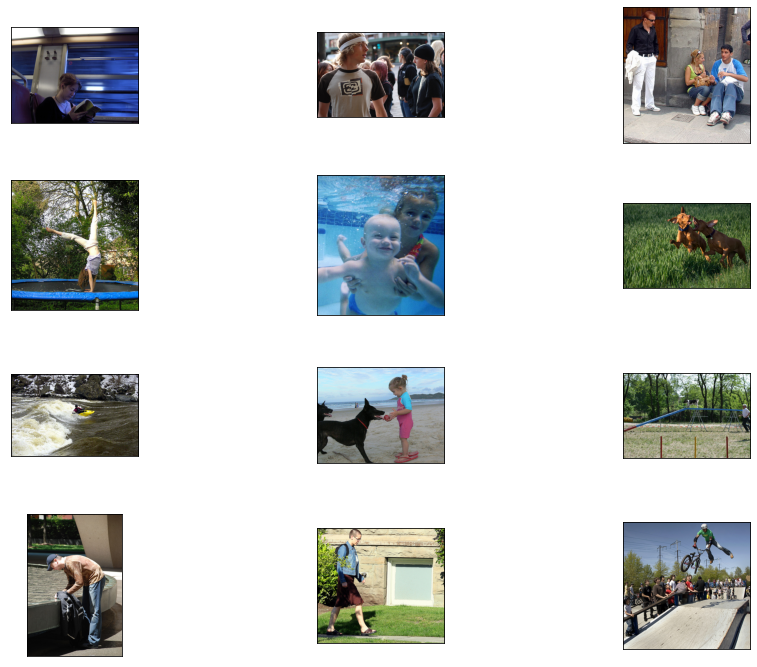

In [6]:
# Visualise the images present in the dataset
num_rows = 4
num_cols =3
num_imgs = num_rows * num_cols
plt.figure(figsize=(16,12))

for i in range(num_imgs):
    plt.subplot(num_rows,2*num_cols, 2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(mpimg.imread(imgs[i]))

In [7]:
# Visualise the text present in the text_path
file = open(text_path,'r')
txt = file.read()
file.close()
print(txt[:400])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a 


In [8]:
# create a list of captions and path
def load_text(path):
    file =open(path,'r')
    text = list(filter(None, (line.rstrip() for line in file)))
    file.close()
    
    lst_line = []
    for line in text:
        lst_line.append(line.split(',',maxsplit=1))
    return lst_line    

content = load_text(text_path)
print(content[:10])

[['image', 'caption'], ['1000268201_693b08cb0e.jpg', 'A child in a pink dress is climbing up a set of stairs in an entry way .'], ['1000268201_693b08cb0e.jpg', 'A girl going into a wooden building .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing into a wooden playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl climbing the stairs to her playhouse .'], ['1000268201_693b08cb0e.jpg', 'A little girl in a pink dress going into a wooden cabin .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a spotted dog are fighting'], ['1001773457_577c3a7d70.jpg', 'A black dog and a tri-colored dog playing with each other on the road .'], ['1001773457_577c3a7d70.jpg', 'A black dog and a white dog with brown spots are staring at each other in the street .'], ['1001773457_577c3a7d70.jpg', 'Two dogs of different breeds looking at each other on the road .']]


#### Create dataframe:

Create a dataframe which summarizes the image, path & captions as a dataframe.

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
# create df
all_img_id = [i[0] for i in content[1:]]     # to store all the image id 
all_img_path = ['/content/gdrive/MyDrive/Eye_for_blind/images/'+ i[0] for i in content[1:]] #store all the image path 
all_captions = [i[1] for i in content[1:]]  #store all the captions 

df = pd.DataFrame(list(zip(all_img_id,all_img_path,all_captions)),columns = ['ID','Path','Captions'])
df.head(8)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,/content/gdrive/MyDrive/Eye_for_blind/images/1...,A black dog and a white dog with brown spots a...


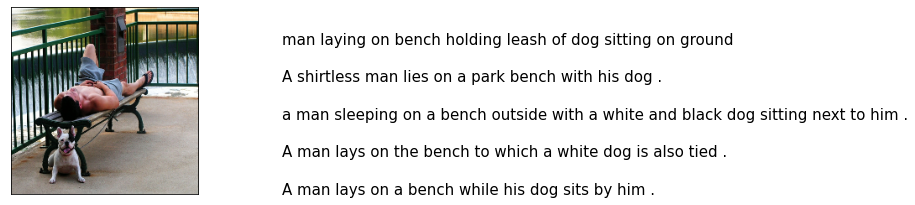

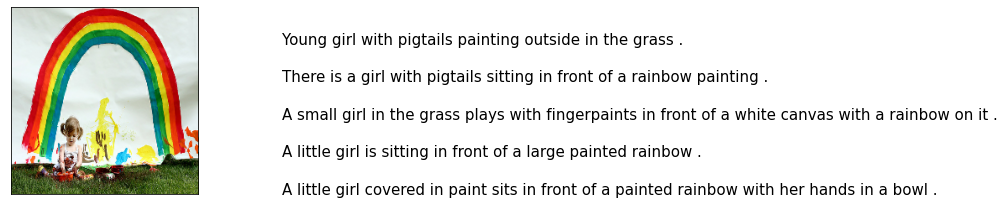

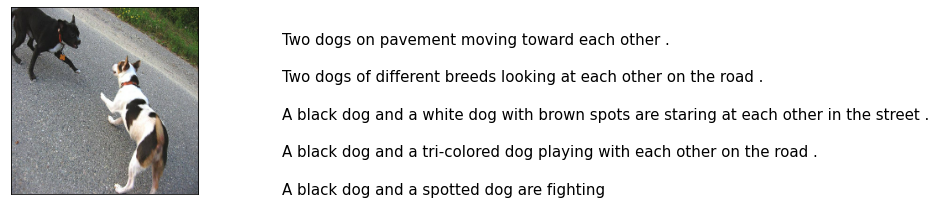

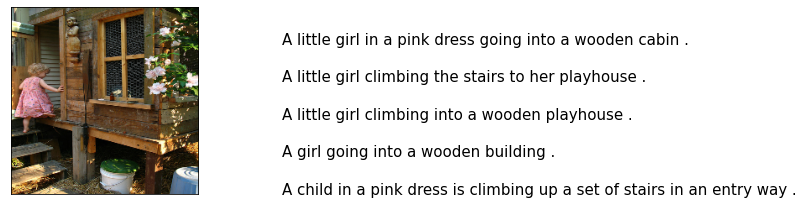

In [10]:
# Visualize some the images along with their captions

img_path=list(set(df.Path[:20]))   # each image has 5 captions. 20/5 = 4 images
count = 1
j=0
for path in img_path:
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
      
    fig = plt.figure(figsize=(10,20))
    ax = fig.add_subplot(5,2,count,xticks=[],yticks=[])
    ax.imshow(img)
    

    count += 1
      
    ax = fig.add_subplot(5,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,5)
    
    img_cap=df.loc[df['Path'] == path, 'Captions']
    
    for i in range(len(img_cap)):
        ax.text(0,i,img_cap.iloc[i],fontsize=15)
    count += 1
    j+=1
plt.show()



In [11]:
#Create the vocabulary & the counter for the captions

voc=[]
for sent in df['Captions']:
    for word in sent.lower().split():
        voc.append(word)
        
voc_count = Counter(voc)
voc_count

Counter({'a': 61752,
         'child': 1535,
         'in': 18965,
         'pink': 735,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 2399,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3320,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1754,
         'playhouse': 6,
         'the': 18249,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3825,
         'dog': 8126,
         'and': 8851,
         'spotted': 37,
         'are': 3504,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7761,
         'each': 430,
         'other': 772,
         'on': 10732,
         'road': 388,
         'white': 3935,
         'brown': 2549,
         'spots': 29,
         'staring': 57,
         'at': 

Text(0.5, 1.0, 'Top 30 occurinng words')

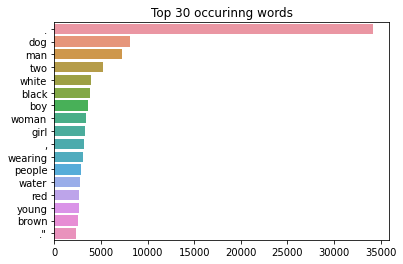

In [12]:
#Visualise the top 30 occuring words in the captions

sort_lst = voc_count.most_common(30)
stop=set(stopwords.words('english'))
x, y=[], []
for word,count in sort_lst:
    if (word.lower() not in stop):
        x.append(word)
        y.append(count)
            
sns.barplot(x=y,y=x).set_title('Top 30 occurinng words')

In [13]:
#Create a list which contains all the captions
# add <start> and <end> tokens
annotations = ['<start>'+ i + '<end>' for i in df.Captions]
print('Captions after adding start and end tokens',annotations[:8])

#Create a list which contains all the path to the images
all_img_path = [i for i in df.Path]
      
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Captions after adding start and end tokens ['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>', '<start>A girl going into a wooden building .<end>', '<start>A little girl climbing into a wooden playhouse .<end>', '<start>A little girl climbing the stairs to her playhouse .<end>', '<start>A little girl in a pink dress going into a wooden cabin .<end>', '<start>A black dog and a spotted dog are fighting<end>', '<start>A black dog and a tri-colored dog playing with each other on the road .<end>', '<start>A black dog and a white dog with brown spots are staring at each other in the street .<end>']
Total captions present in the dataset: 40455
Total images present in the dataset: 40455


# 2. Data preprocessing:

#### Preprocess Captions:

1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be of the same length as the longest one.

In [14]:
# create the tokenizer

top_k = 5000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)


# Create word-to-index and index-to-word mappings.
word_index = tokenizer.word_index   
index_word = tokenizer.index_word

train_seqs = tokenizer.texts_to_sequences(annotations)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

print('Caption: \n', annotations[1])
print('The train sequence is: \n', train_seqs[1])

Caption: 
 <start>A girl going into a wooden building .<end>
The train sequence is: 
 [4, 21, 321, 65, 2, 200, 124, 3]


In [15]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

# Find the maximum length of a caption
max_length = max([len(x) for x in train_seqs])
print("maxium length of a caption:\n", max_length)

# pad captions in the train seqs to reach max length with 0's
cap_vector = keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_length)

print("Padded training sequences:\n", cap_vector[1])

print("The shape of Caption vector is :" + str(cap_vector.shape))


maxium length of a caption:
 40
Padded training sequences:
 [  4  21 321  65   2 200 124   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
The shape of Caption vector is :(40455, 40)


####  Preprocess Images:

1.Resize them into the shape of (299, 299)

2.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [16]:
#Preprocess images
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    return img, image_path

# Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)


In [17]:
# initialize model and load pretrained weights
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

#model
base_model = keras.Model(new_input, hidden_layer)
base_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_____________________________

In [18]:
# get unique images
encode_train = sorted(set(all_img_path))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# resize image and normalize
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

In [19]:
#save image features into .npy
for img, path in tqdm(image_dataset):
    batch_features = base_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
 

100%|██████████| 127/127 [35:20<00:00, 16.70s/it]


# Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [20]:
# Shuffle captions and image_names together
all_img_path, cap_vector = shuffle(all_img_path,
                                          cap_vector,
                                          random_state=1)

# Create training and validation sets using an 80-20 split
img_train, img_test, cap_train, cap_test = train_test_split(all_img_path,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=42)

print("Training data for images: " + str(len(img_train)))
print("Testing data for images: " + str(len(img_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [21]:
# Set Batch and Buffer Size

BATCH_SIZE = 64
BUFFER_SIZE = 2000

# To load image features

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy') 
    return img_tensor, cap

In [22]:
def gen_dataset(img_data, cap_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((img_data, cap_data))
    dataset = dataset.shuffle(BUFFER_SIZE)
    
    # to load numpy files
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [24]:
train_dataset=gen_dataset(img_train,cap_train)
test_dataset=gen_dataset(img_test,cap_test)

In [25]:
# sample
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
print(sample_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 40)


# Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [26]:
#Set the parameters

embedding_dim = 256
units = 512
vocab_size = top_k + 1
train_num_steps = len(img_train) // BATCH_SIZE
test_num_steps = len(img_test) // BATCH_SIZE
features_shape = bf.shape[1]
attention_features_shape = bf.shape[0]

### CNN - Encoder:

In [27]:
class CNN_Encoder(keras.Model):
    # to pass extracted features through FC layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = layers.Dense(embedding_dim)
        #self.dropout = layers.Dropout(0.5)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

### Attention model:

In [28]:
class Attention_model(keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 64, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # To expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) 
        # build score funciton to shape: (batch_size, 8*8, units)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) 
        # to extract attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) 
        #create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

### Decoder:

In [29]:
class Decoder(keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        #iniitalise Attention model with units
        self.attention = Attention_model(self.units) 
        #build Embedding layer
        self.embed = layers.Embedding(vocab_size, embed_dim,mask_zero=True)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)
        #self.dropout = Dropout(0.5)
        

    def call(self,x,features, hidden):
        #create context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        
        # embed input to shape: 
        embed = self.embed(x) #shape: (batch_size, 1, embedding_dim)
    
        # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) 
        
        # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output,state = self.gru(embed) # output shape : (batch_size, max_length, hidden_size)
        output = self.fc1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.fc2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    


In [30]:
# init
encoder = CNN_Encoder(embedding_dim)
attention = Attention_model(units)
decoder = Decoder(embedding_dim, units, vocab_size)

In [31]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


# Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [32]:
# Set Optmizer and Loss Object
optimizer = tf.keras.optimizers.RMSprop()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [33]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [34]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [35]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [36]:
# train function - teacher forcing
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        
    avg_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
       
    return loss, avg_loss

In [37]:
# test function - without teacher forcing
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)

        predicted_id =  tf.argmax(predictions,1)
        dec_input = tf.expand_dims(predicted_id, 1)
        
    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [40]:
# test loss function
def test_loss_cal(test_dataset):
    total_loss_test = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss_test += t_loss
        avg_test_loss=total_loss_test / test_num_steps

    
    return avg_test_loss

In [41]:
# model training
loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/20 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.015, & test loss is 1.741
Time taken for 1 epoch 312.63397216796875 sec

Test loss has been reduced from 100.000 to 1.741


 10%|█         | 2/20 [08:57<1:18:15, 260.84s/it]

For epoch: 2, the train loss is 0.950, & test loss is 1.804
Time taken for 1 epoch 224.37522172927856 sec

For epoch: 3, the train loss is 0.904, & test loss is 1.723
Time taken for 1 epoch 225.05431008338928 sec

Test loss has been reduced from 1.741 to 1.723


 20%|██        | 4/20 [16:28<1:03:17, 237.35s/it]

For epoch: 4, the train loss is 0.867, & test loss is 1.742
Time taken for 1 epoch 226.15684032440186 sec



 25%|██▌       | 5/20 [20:14<58:16, 233.12s/it]  

For epoch: 5, the train loss is 0.834, & test loss is 1.855
Time taken for 1 epoch 225.58271098136902 sec



 30%|███       | 6/20 [24:14<54:58, 235.59s/it]

For epoch: 6, the train loss is 0.803, & test loss is 1.820
Time taken for 1 epoch 240.33841967582703 sec



 35%|███▌      | 7/20 [28:01<50:25, 232.75s/it]

For epoch: 7, the train loss is 0.774, & test loss is 1.852
Time taken for 1 epoch 226.8723599910736 sec



 40%|████      | 8/20 [32:01<46:59, 234.94s/it]

For epoch: 8, the train loss is 0.747, & test loss is 1.890
Time taken for 1 epoch 239.58788132667542 sec



 45%|████▌     | 9/20 [35:47<42:33, 232.10s/it]

For epoch: 9, the train loss is 0.721, & test loss is 1.887
Time taken for 1 epoch 225.8178300857544 sec



 50%|█████     | 10/20 [39:33<38:23, 230.37s/it]

For epoch: 10, the train loss is 0.697, & test loss is 1.899
Time taken for 1 epoch 226.47197699546814 sec



 55%|█████▌    | 11/20 [43:20<34:23, 229.29s/it]

For epoch: 11, the train loss is 0.675, & test loss is 1.961
Time taken for 1 epoch 226.80351901054382 sec



 60%|██████    | 12/20 [47:20<31:00, 232.57s/it]

For epoch: 12, the train loss is 0.654, & test loss is 2.091
Time taken for 1 epoch 240.0180640220642 sec



 65%|██████▌   | 13/20 [51:05<26:51, 230.19s/it]

For epoch: 13, the train loss is 0.634, & test loss is 2.085
Time taken for 1 epoch 224.68336629867554 sec



 70%|███████   | 14/20 [54:49<22:50, 228.38s/it]

For epoch: 14, the train loss is 0.616, & test loss is 2.137
Time taken for 1 epoch 224.14498162269592 sec



 75%|███████▌  | 15/20 [58:34<18:57, 227.41s/it]

For epoch: 15, the train loss is 0.603, & test loss is 2.141
Time taken for 1 epoch 225.11769914627075 sec



 80%|████████  | 16/20 [1:02:18<15:05, 226.42s/it]

For epoch: 16, the train loss is 0.589, & test loss is 2.128
Time taken for 1 epoch 224.09829878807068 sec



 85%|████████▌ | 17/20 [1:06:02<11:17, 225.74s/it]

For epoch: 17, the train loss is 0.576, & test loss is 2.140
Time taken for 1 epoch 224.1175501346588 sec



 90%|█████████ | 18/20 [1:09:47<07:30, 225.29s/it]

For epoch: 18, the train loss is 0.561, & test loss is 2.161
Time taken for 1 epoch 224.19450974464417 sec



 95%|█████████▌| 19/20 [1:13:32<03:45, 225.16s/it]

For epoch: 19, the train loss is 0.547, & test loss is 2.129
Time taken for 1 epoch 224.8271176815033 sec



100%|██████████| 20/20 [1:17:18<00:00, 231.95s/it]

For epoch: 20, the train loss is 0.534, & test loss is 2.186
Time taken for 1 epoch 226.79764699935913 sec



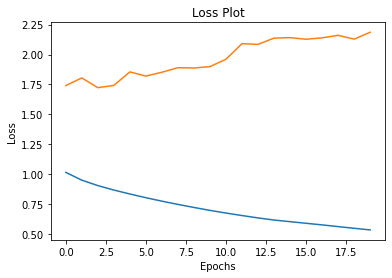

In [42]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score


### Greedy search:

In [43]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)
    #process the input image to desired format before extracting features
    temp_input = tf.expand_dims(load_image(image)[0], 0) 
    
    # Extract features using our feature extraction model
    img_tensor_val = base_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        #map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [65]:
def plot_attmap(image, result, attention_plot):

    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [66]:
# to filter unwanted tokens 
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

# Prediction:

In [76]:
# function for prediction and text to speech conversion

def pred_speech():
    # take a random image
    rid = np.random.randint(0, len(img_test))
    test_image = img_test[rid]
    
    # print original image
    print('Original image:')
    plt.imshow(mpimg.imread(test_image),interpolation='nearest',aspect='auto')
    Image.open(test_image)
    plt.title('Selected Image for testing:')
    plt.grid(None)
    print("#"*100) 
    
    # print the real caption 
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    real_caption=filt_text(real_caption)
    print ('Real Caption:', real_caption)
    print("#"*100)
    
    #print predicted caption
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    print ('Prediction Caption:', pred_caption)
    print("#"*100)
    
    # to print Belu score    
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    
    # Belu score for different weights
    print('BELU score 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
    print('BELU score 2-gram: %f' % sentence_bleu(reference, candidate, weights=(.5, .5, 0, 0)))
    print('BELU score 3-gram: %f' % sentence_bleu(reference, candidate, weights=(.33, .33, .33, 0)))
    print('BELU score 4-gram: %f' % sentence_bleu(reference, candidate, weights=(.25, .25,.25, .25)))
    print("#"*100)
    
    # to plot Captions generated by Attention model along with images 
    print('Captions generated by Attention model:')
    plot_attmap(test_image, result, attention_plot)
    print("#"*100)

    # to convert text to speech
    print('Audio for the predicted caption:')                      
    language = 'en'
    txt_spch = gTTS(text=pred_caption, lang=language, slow=False)
    txt_spch.save("text_to_speech.mp3")                      
                          
                          

## Testing:

Original image:
####################################################################################################
Real Caption: <start>someone is skiing down a step snowy hill
####################################################################################################
Prediction Caption: skier is skiing in the snow
####################################################################################################
BELU score 1-gram: 0.238844
BELU score 2-gram: 0.185008
BELU score 3-gram: 0.293174
BELU score 4-gram: 0.364093
####################################################################################################
Captions generated by Attention model:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


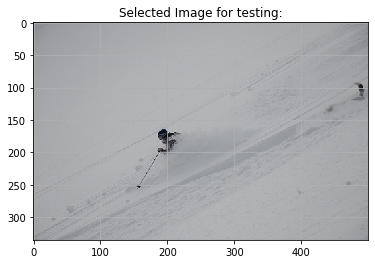

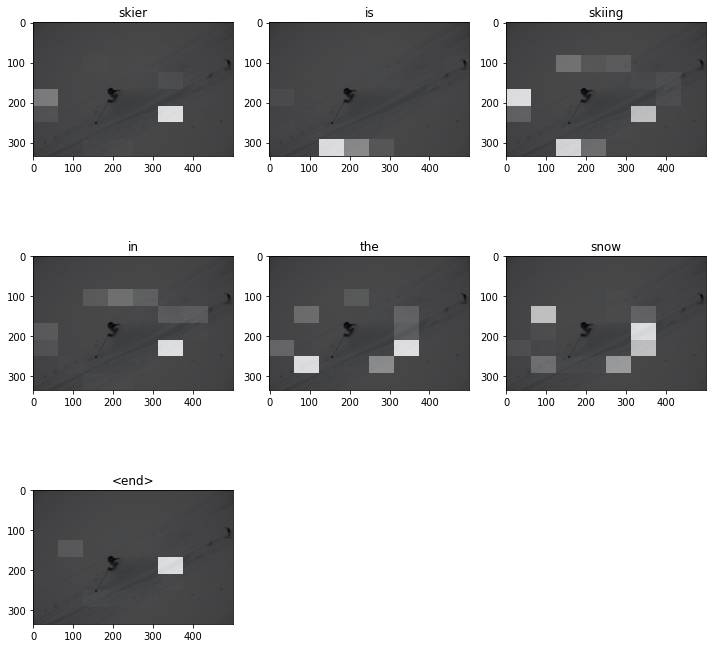

####################################################################################################
Audio for the predicted caption:


In [77]:
#test 1
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: <start>someone climbs a rocks
####################################################################################################
Prediction Caption: rock climber are climbing a rock wall
####################################################################################################
BELU score 1-gram: 0.142857
BELU score 2-gram: 0.377964
BELU score 3-gram: 0.526160
BELU score 4-gram: 0.614788
####################################################################################################
Captions generated by Attention model:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


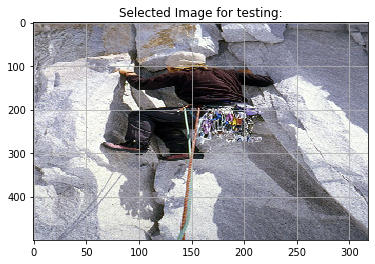

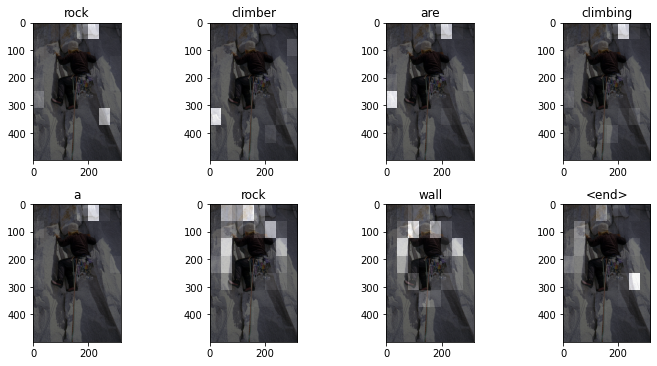

####################################################################################################
Audio for the predicted caption:


In [78]:
#test 2
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)

Original image:
####################################################################################################
Real Caption: <start>young woman in pink does skateboarding figure
####################################################################################################
Prediction Caption: girl in a pink tank top is sliding on a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along a skateboard along
####################################################################################################
BELU score 1-gram: 0.051282
BELU score 2-gram: 0.226455
BELU score 3-gram: 0.375222
BELU score 4-gram: 0.475873
####################################################################################################
Captions generated by Attention model:


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  from ipykernel import kernelapp as app


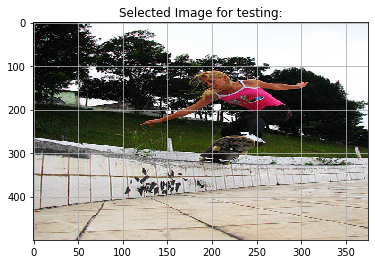

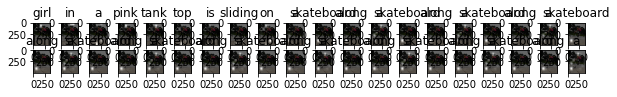

####################################################################################################
Audio for the predicted caption:


In [79]:
#test 3
pred_speech()
Audio("text_to_speech.mp3", autoplay=True)